<a href="https://colab.research.google.com/github/sania27-12/sania27-12/blob/main/IDS_CA2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CA2


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32581 entries, 0 to 32580
Data columns (total 12 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   person_age                  32581 non-null  int64  
 1   person_income               32581 non-null  int64  
 2   person_home_ownership       32581 non-null  object 
 3   person_emp_length           31686 non-null  float64
 4   loan_intent                 32581 non-null  object 
 5   loan_grade                  32581 non-null  object 
 6   loan_amnt                   32581 non-null  int64  
 7   loan_int_rate               29465 non-null  float64
 8   loan_status                 32581 non-null  int64  
 9   loan_percent_income         32581 non-null  float64
 10  cb_person_default_on_file   32581 non-null  object 
 11  cb_person_cred_hist_length  32581 non-null  int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 3.0+ MB
None

Missing Val

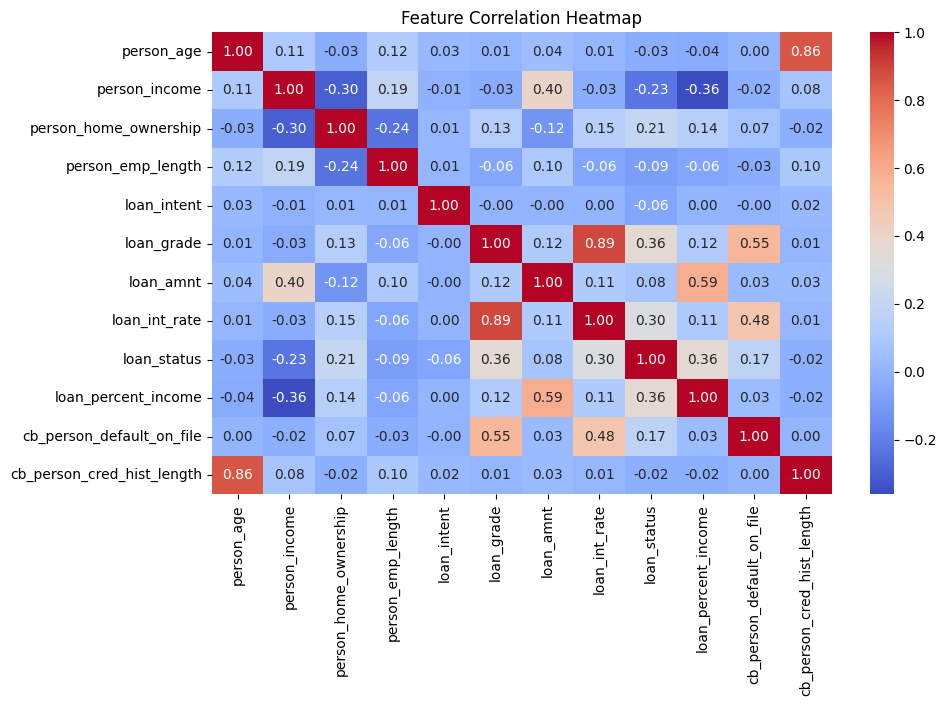

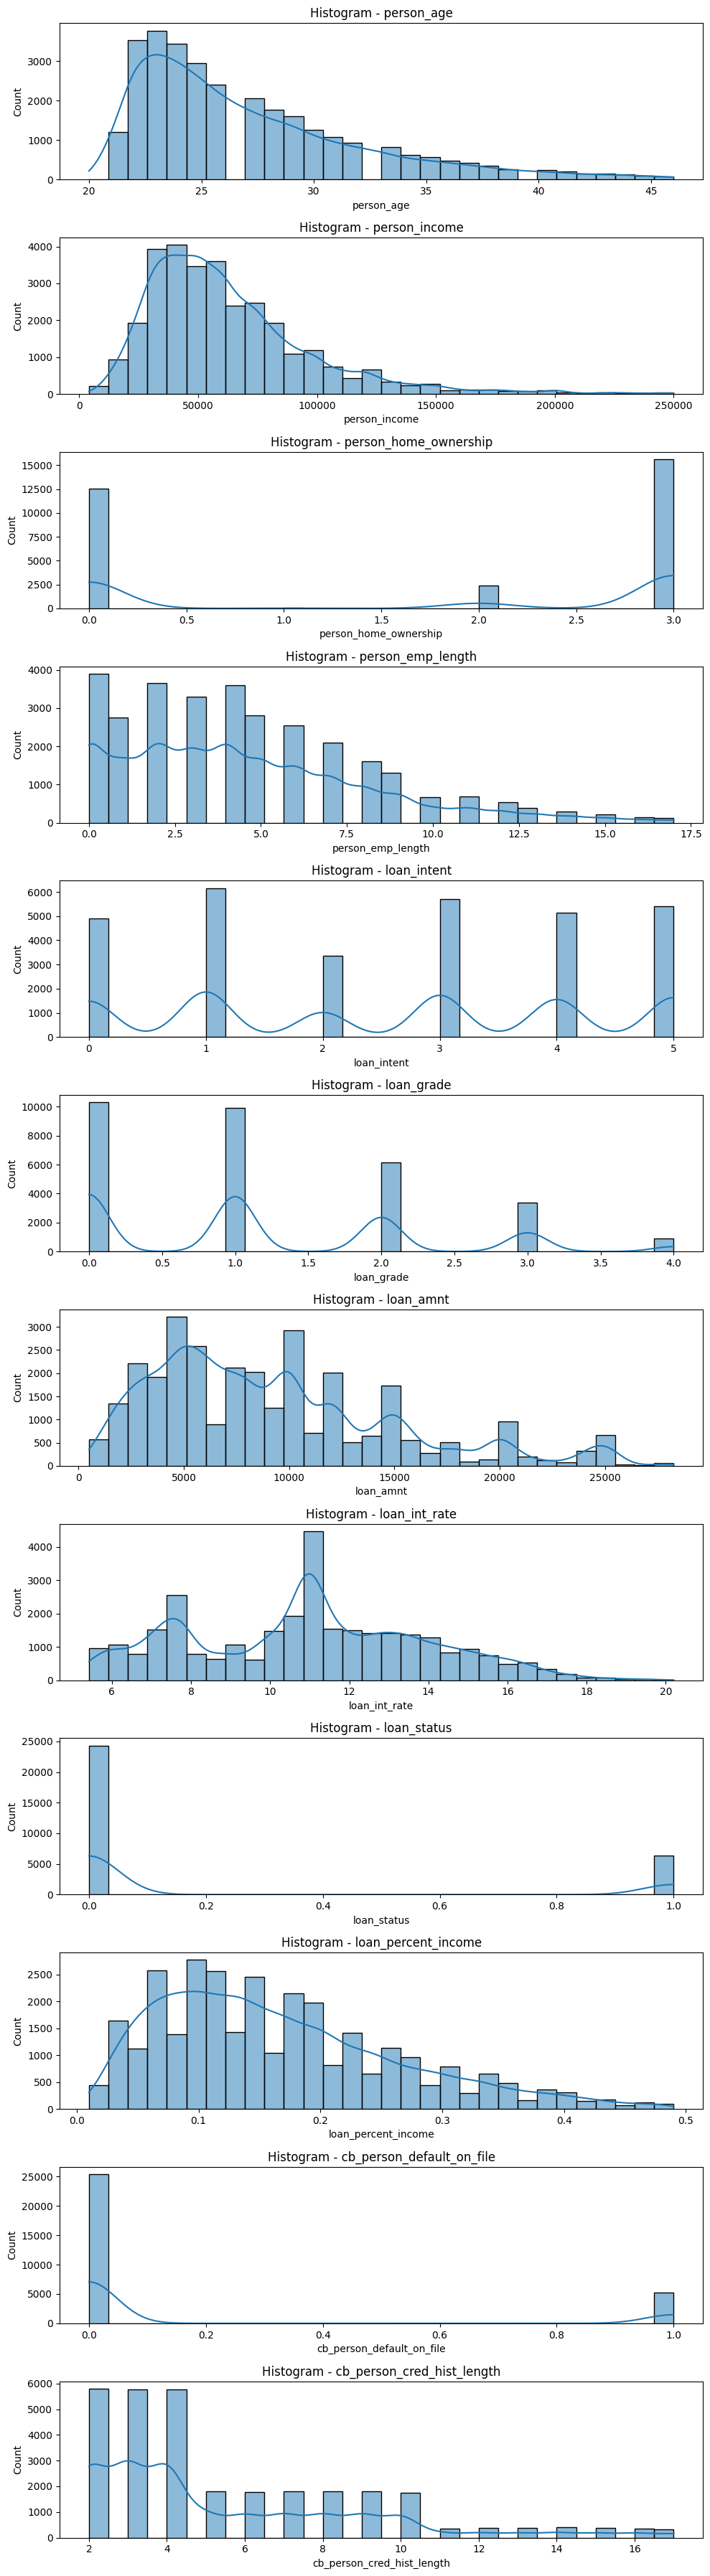

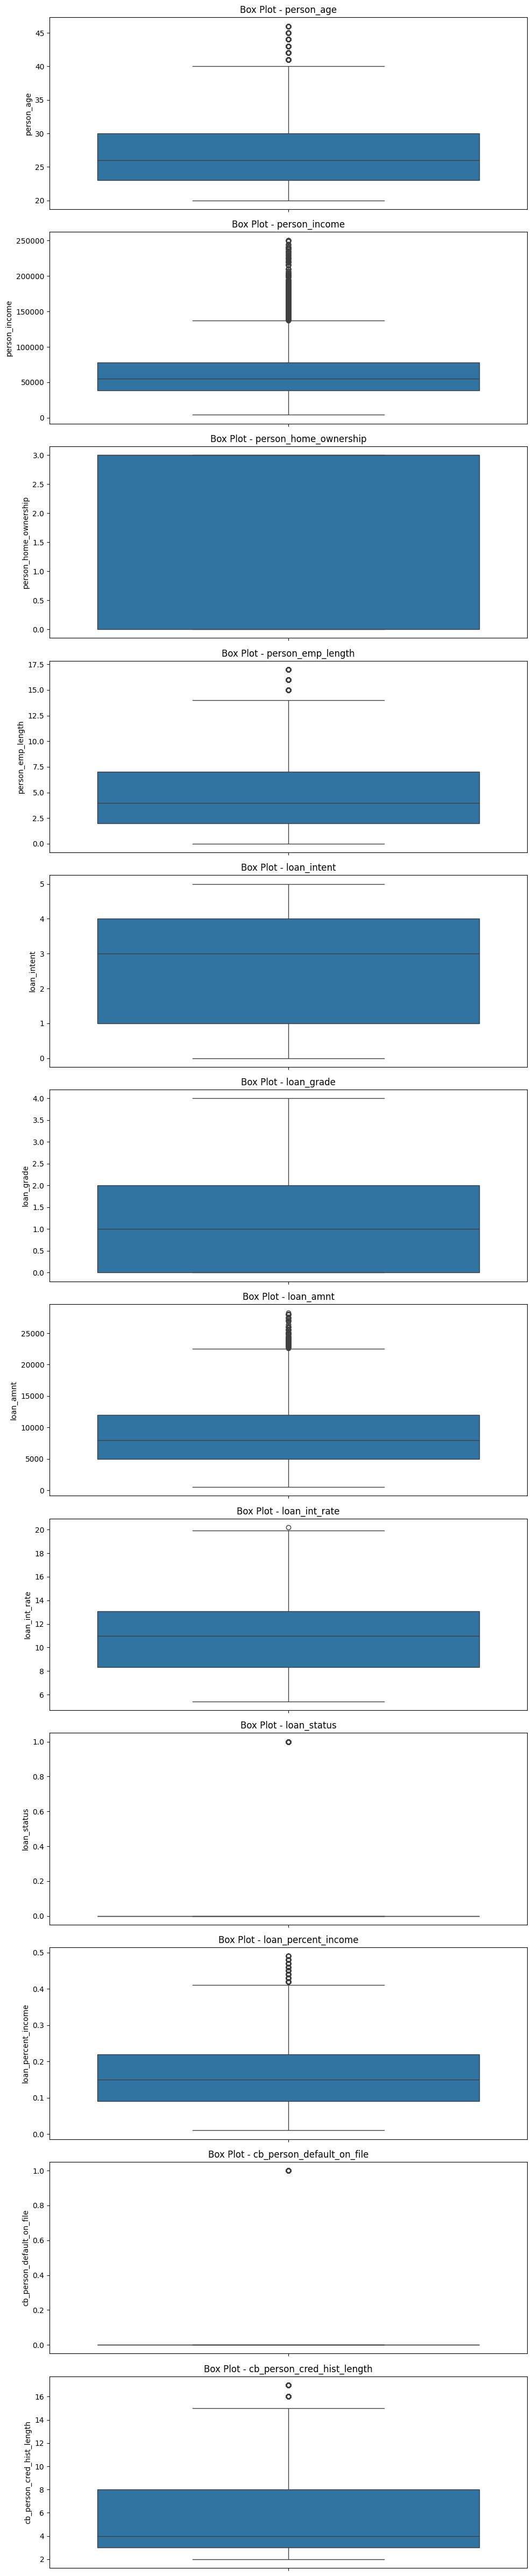

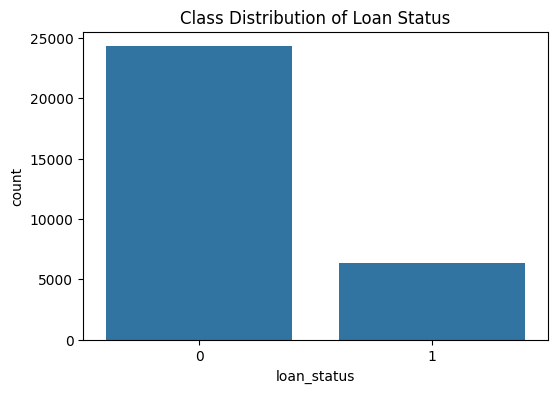


Final Dataset Shape: (30649, 12)

Model Evaluation - Random Forest
              precision    recall  f1-score   support

           0       0.96      1.00      0.98      4863
           1       0.98      0.84      0.91      1267

    accuracy                           0.96      6130
   macro avg       0.97      0.92      0.94      6130
weighted avg       0.97      0.96      0.96      6130

Accuracy: 0.9646
Precision: 0.9817
Recall: 0.8445
F1-Score: 0.9079
RMSE: 0.1881
R² Score: 0.7841

Model Evaluation - XGBoost
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      4863
           1       0.96      0.78      0.86      1267

    accuracy                           0.95      6130
   macro avg       0.95      0.88      0.91      6130
weighted avg       0.95      0.95      0.94      6130

Accuracy: 0.9470
Precision: 0.9582
Recall: 0.7774
F1-Score: 0.8584
RMSE: 0.2303
R² Score: 0.6767


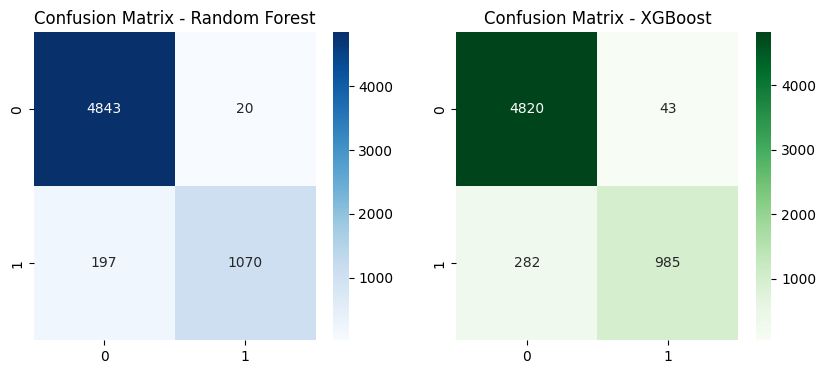

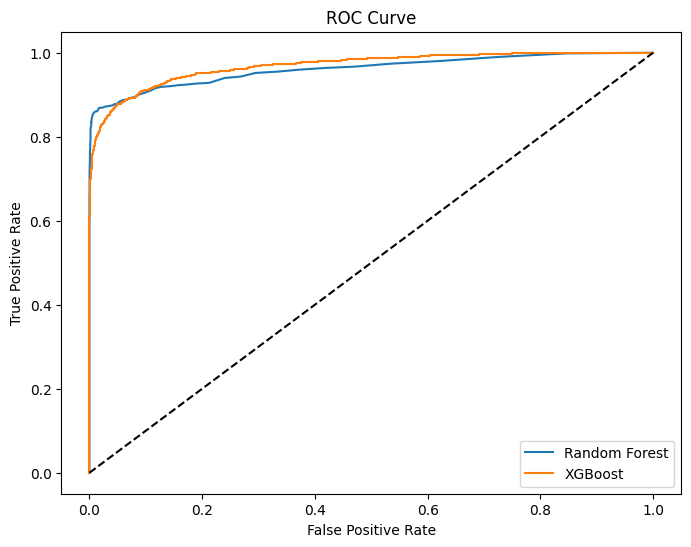

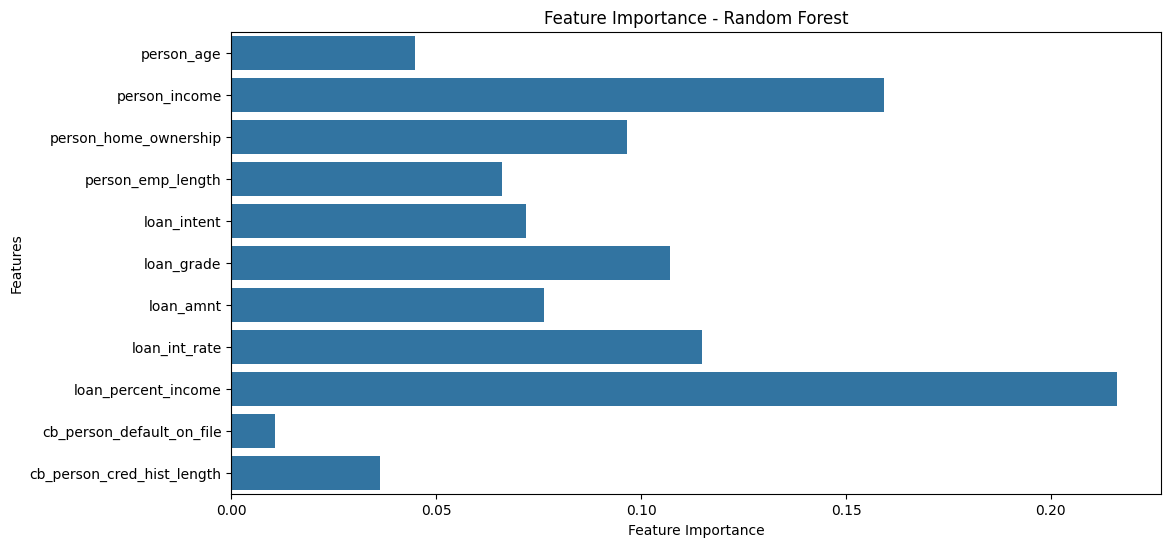

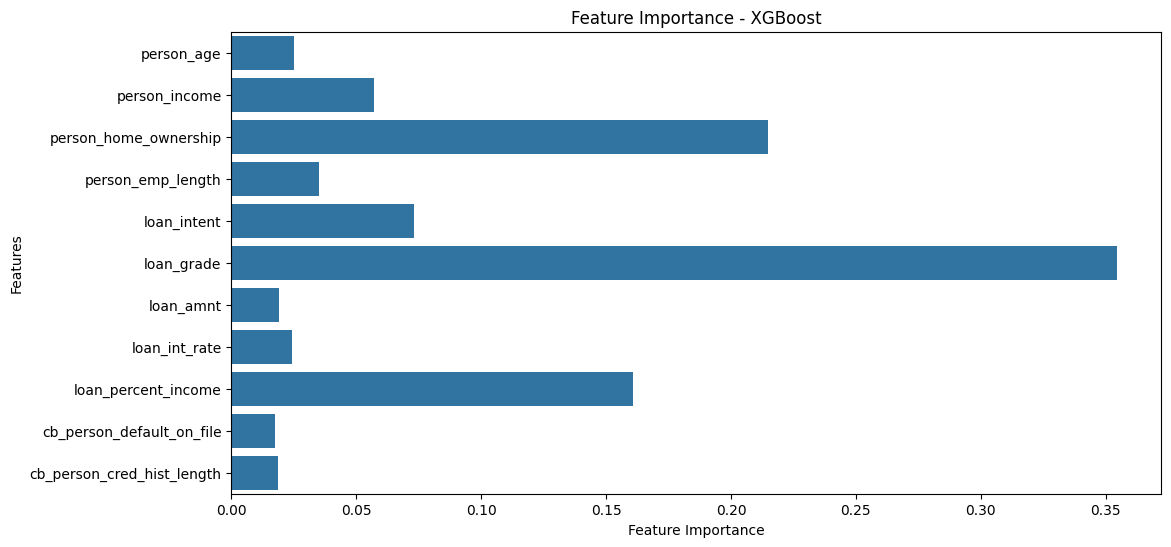

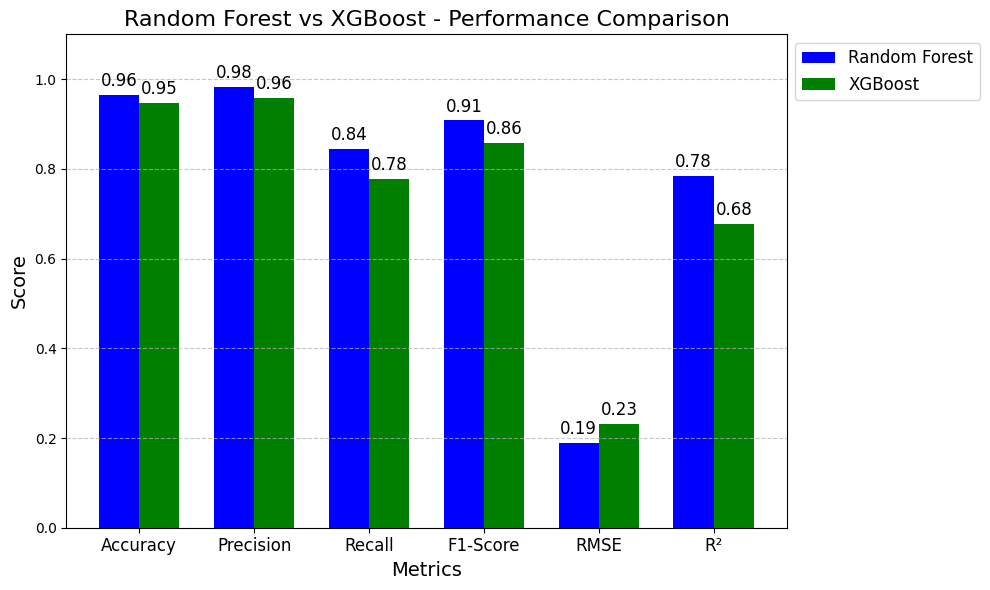

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_curve, confusion_matrix, classification_report, mean_squared_error, r2_score
)

# Load dataset
df = pd.read_csv("/content/sample_data/credit_risk_dataset.csv")

# Display basic info
print("Dataset Info:")
print(df.info())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Fill missing values (numeric: median, categorical: mode)
df.fillna({col: df[col].mode()[0] for col in df.select_dtypes(include=['object']).columns}, inplace=True)
df.fillna({col: df[col].median() for col in df.select_dtypes(include=[np.number]).columns}, inplace=True)

# Convert categorical columns to numerical using Label Encoding
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    label_encoders[col] = LabelEncoder()
    df[col] = label_encoders[col].fit_transform(df[col])

# Detect and handle outliers using Z-score
z_scores = np.abs(zscore(df.select_dtypes(include=[np.number])))
df = df[(z_scores < 3).all(axis=1)]

# Correlation heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

# Histogram plots
num_cols = df.select_dtypes(include=[np.number]).columns
fig, axes = plt.subplots(nrows=len(num_cols), ncols=1, figsize=(10, len(num_cols) * 3))
for i, col in enumerate(num_cols):
    sns.histplot(df[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(f"Histogram - {col}")
plt.tight_layout()
plt.show()

# Box Plot for Numerical Features (Stacked Layout)
df_numeric = df.select_dtypes(include=[np.number])
plt.figure(figsize=(10, len(df_numeric.columns) * 4))
for i, col in enumerate(df_numeric.columns, 1):
    plt.subplot(len(df_numeric.columns), 1, i)
    sns.boxplot(y=df[col])
    plt.title(f"Box Plot - {col}")
plt.tight_layout()
plt.show()

# Check for class imbalance
plt.figure(figsize=(6, 4))
sns.countplot(x=df['loan_status'])
plt.title("Class Distribution of Loan Status")
plt.show()

# Handle imbalance using oversampling
loan_counts = df['loan_status'].value_counts()
min_class = loan_counts.idxmin()
min_count = loan_counts.min()

df_balanced = df[df['loan_status'] == min_class].sample(n=min_count, replace=True)
df = pd.concat([df[df['loan_status'] != min_class], df_balanced])


print("\nFinal Dataset Shape:", df.shape)

# Splitting Data
X = df.drop(columns=["loan_status"])
y = df["loan_status"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# Train XGBoost Model
xgb_model = XGBClassifier(eval_metric='logloss')
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Model Evaluation Function
def evaluate_model(model_name, y_test, y_pred):
    print(f"\nModel Evaluation - {model_name}")
    print(classification_report(y_test, y_pred))
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    return accuracy, precision, recall, f1, rmse, r2

rf_results = evaluate_model("Random Forest", y_test, y_pred_rf)
xgb_results = evaluate_model("XGBoost", y_test, y_pred_xgb)

# Confusion Matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix - Random Forest")
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred_xgb), annot=True, fmt="d", cmap="Greens")
plt.title("Confusion Matrix - XGBoost")
plt.show()

# ROC Curve
plt.figure(figsize=(8, 6))
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test)[:, 1])
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot(fpr_xgb, tpr_xgb, label="XGBoost")
plt.plot([0, 1], [0, 1], linestyle="--", color="black")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

# Feature Importance - Random Forest
plt.figure(figsize=(12, 6))
sns.barplot(x=rf_model.feature_importances_, y=X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Random Forest")
plt.show()

# Feature Importance - XGBoost
plt.figure(figsize=(12, 6))
sns.barplot(x=xgb_model.feature_importances_, y=X.columns)
plt.xlabel("Feature Importance")
plt.ylabel("Features")
plt.title("Feature Importance - XGBoost")
plt.show()

# Comparison Graph for Model Metrics
metrics = ["Accuracy", "Precision", "Recall", "F1-Score", "RMSE", "R²"]
rf_scores = list(rf_results)
xgb_scores = list(xgb_results)

# Set positions for bars
x = np.arange(len(metrics))

plt.figure(figsize=(10, 6))
bar_width = 0.35

# Plot bars with better spacing
bars1 = plt.bar(x - bar_width/2, rf_scores, width=bar_width, label="Random Forest", color="blue")
bars2 = plt.bar(x + bar_width/2, xgb_scores, width=bar_width, label="XGBoost", color="green")

# Add value labels on top of bars
for bar in bars1 + bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f"{yval:.2f}", ha="center", fontsize=12)

# Labels & Title
plt.xlabel("Metrics", fontsize=14)
plt.ylabel("Score", fontsize=14)
plt.title("Random Forest vs XGBoost - Performance Comparison", fontsize=16)
plt.xticks(ticks=x, labels=metrics, fontsize=12)
plt.ylim(0, 1.1)  # Adjusted y-axis range for clarity

# Move legend outside the plot
plt.legend(loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

# Add grid for better readability
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Show plot
plt.tight_layout()  # Adjusts layout to prevent overlap
plt.show()

